### 0. 환경 설정

In [1]:
# ==== 셀 0: 환경 설정 ====

import os
import cv2
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# GPU / CPU 자동 선택
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("사용 디바이스:", DEVICE)

# 데이터셋 루트 경로 (수정해서 사용하세요)
DATA_ROOT = Path(r"266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축/01-1.정식개방데이터")

# 학습 / 검증 경로
TRAIN_IMG_DIRS = [
    DATA_ROOT / "Training/01.원천데이터/TS_나무",
    DATA_ROOT / "Training/01.원천데이터/TS_남자사람",
    DATA_ROOT / "Training/01.원천데이터/TS_여자사람",
    DATA_ROOT / "Training/01.원천데이터/TS_집",
]
TRAIN_LABEL_DIRS = [
    DATA_ROOT / "Training/02.라벨링데이터/TL_나무",
    DATA_ROOT / "Training/02.라벨링데이터/TL_남자사람",
    DATA_ROOT / "Training/02.라벨링데이터/TL_여자사람",
    DATA_ROOT / "Training/02.라벨링데이터/TL_집",
]

VAL_IMG_DIRS = [
    DATA_ROOT / "Validation/01.원천데이터/VS_나무",
    DATA_ROOT / "Validation/01.원천데이터/VS_남자사람",
    DATA_ROOT / "Validation/01.원천데이터/VS_여자사람",
    DATA_ROOT / "Validation/01.원천데이터/VS_집",
]
VAL_LABEL_DIRS = [
    DATA_ROOT / "Validation/02.라벨링데이터/VL_나무",
    DATA_ROOT / "Validation/02.라벨링데이터/VL_남자사람",
    DATA_ROOT / "Validation/02.라벨링데이터/VL_여자사람",
    DATA_ROOT / "Validation/02.라벨링데이터/VL_집",
]

# 클래스 정의
CLASSES = ["나무", "남자사람", "여자사람", "집"]
print("클래스:", CLASSES)


사용 디바이스: cuda
클래스: ['나무', '남자사람', '여자사람', '집']


### 1. 멀티 스케일 데이터 증강

In [2]:
import torchvision.transforms as T
from PIL import Image

# 학습용 변환
transform_train = T.Compose([
    T.RandomResizedCrop(size=(416,416), scale=(0.5,1.5)),  # 멀티 스케일
    T.RandomHorizontalFlip(p=0.5),  # 좌우 반전
    T.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 랜덤 변화
    T.ToTensor()
])

# 검증용 변환 (단순 리사이즈)
transform_val = T.Compose([
    T.Resize((416,416)),
    T.ToTensor()
])

print("데이터 증강 준비 완료!")


데이터 증강 준비 완료!


### 2. 오츠 이진화 + 배경 역전환

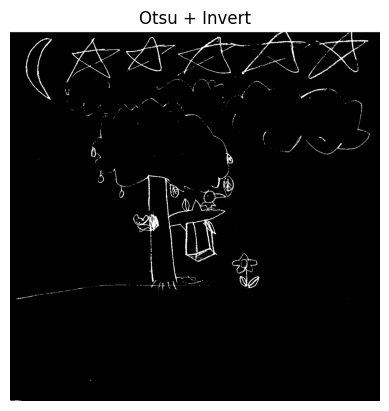

In [3]:
import numpy as np

def preprocess_binary(img_path):
    """
    입력: 이미지 경로
    출력: 이진화 + 반전 이미지
    """
    # 한글 경로 지원 (np.fromfile + imdecode)
    img = cv2.imdecode(np.fromfile(str(img_path), dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {img_path}")

    # 그레이 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 오츠 이진화
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 반전 (배경 검정, 선 흰색)
    inverted = cv2.bitwise_not(binary)
    return inverted

# =====================
# 샘플 확인
# =====================
sample_img = Path(r"266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축/01-1.정식개방데이터/Training/01.원천데이터/TS_나무/나무_7_남_00242.jpg")
bin_img = preprocess_binary(sample_img)

plt.imshow(bin_img, cmap="gray")
plt.title("Otsu + Invert")
plt.axis("off")
plt.show()


### 3. 노이즈 강화

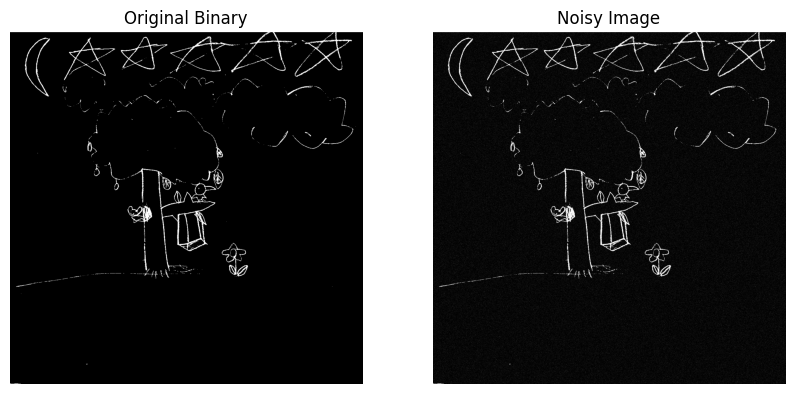

In [4]:
def add_noise(img, sigma=15):
    """
    가우시안 노이즈 추가
    img: 흑백 이미지 (numpy array)
    sigma: 노이즈 표준편차
    """
    row, col = img.shape
    gauss = np.random.normal(0, sigma, (row, col))
    noisy = img.astype(np.float32) + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# =====================
# 샘플 실행
# =====================
noisy_img = add_noise(bin_img, sigma=20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(bin_img, cmap="gray")
plt.title("Original Binary")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(noisy_img, cmap="gray")
plt.title("Noisy Image")
plt.axis("off")
plt.show()


### 4. JSON 라벨 → YOLO 포맷 변환

In [5]:
import json

# YOLO 클래스 정의
CLASSES = ["나무", "남자사람", "여자사람", "집"]

def convert_json_to_yolo(json_path, img_size=1280):
    """
    JSON 라벨 파일을 YOLO 포맷으로 변환
    YOLO 포맷: class_id x_center y_center width height (정규화 값)
    """
    with open(json_path, encoding="utf-8") as f:
        data = json.load(f)

    cls_name = data["annotations"]["class"]
    if cls_name not in CLASSES:
        return []

    class_id = CLASSES.index(cls_name)
    boxes = []
    for bbox in data["annotations"]["bbox"]:
        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]

        # 중심 좌표
        xc = (x + w / 2) / img_size
        yc = (y + h / 2) / img_size
        nw = w / img_size
        nh = h / img_size

        boxes.append([class_id, xc, yc, nw, nh])
    return boxes

# =====================
# 샘플 실행
# =====================
json_path = r"266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축/01-1.정식개방데이터/Training/02.라벨링데이터/TL_나무/나무_7_남_00242.json"
yolo_boxes = convert_json_to_yolo(json_path, img_size=1280)

print("변환된 YOLO 라벨 5개 샘플:")
for b in yolo_boxes[:5]:
    print(b)


변환된 YOLO 라벨 5개 샘플:
[0, 0.4109375, 0.440234375, 0.39375, 0.52734375]
[0, 0.409765625, 0.519140625, 0.08359375, 0.26015625]
[0, 0.40703125, 0.3078125, 0.378125, 0.2640625]
[0, 0.5046875, 0.497265625, 0.1625, 0.08984375]
[0, 0.430078125, 0.67265625, 0.23671875, 0.0609375]


### 5. YOLOv3 모델 (torchvision 사용)

In [6]:
# YOLOv3 설치 (한 번만 실행하면 됨)
!pip install ultralytics==8.0.196 -q

from ultralytics import YOLO

# YOLOv3 사전학습 모델 불러오기 (COCO dataset 기반)
yolo = YOLO("yolov3.pt")  
yolo.to(DEVICE)

print("YOLOv3 모델 로드 완료! 디바이스:", DEVICE)


PRO TIP  Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializatio

YOLOv3 모델 로드 완료! 디바이스: cuda


### 6. 학습 (탐지만)

In [7]:
import os, json, shutil
from pathlib import Path

# === 경로 설정 ===
DATA_ROOT = Path(r"266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축/01-1.정식개방데이터")

OUT_ROOT = Path("dataset_yolo")  # YOLO 학습용 출력 경로
(TRAIN_IMG_OUT, TRAIN_LABEL_OUT) = (OUT_ROOT/"train/images", OUT_ROOT/"train/labels")
(VAL_IMG_OUT, VAL_LABEL_OUT) = (OUT_ROOT/"val/images", OUT_ROOT/"val/labels")

for p in [TRAIN_IMG_OUT, TRAIN_LABEL_OUT, VAL_IMG_OUT, VAL_LABEL_OUT]:
    p.mkdir(parents=True, exist_ok=True)

# 클래스 정의
CLASSES = ["나무", "남자사람", "여자사람", "집"]

def convert_and_copy(img_dir, label_dir, img_out, label_out):
    """
    JSON 라벨을 YOLO txt로 변환 + 이미지 복사
    """
    count = 0
    for json_file in Path(label_dir).glob("*.json"):
        with open(json_file, encoding="utf-8") as f:
            data = json.load(f)
        
        cls_name = data["annotations"]["class"]
        if cls_name not in CLASSES:
            continue
        class_id = CLASSES.index(cls_name)

        # 이미지 경로 (json 파일명과 동일)
        img_name = Path(data["meta"]["img_path"]).name
        src_img = Path(img_dir) / img_name
        dst_img = img_out / img_name
        if not src_img.exists():
            continue
        shutil.copy(src_img, dst_img)

        # JSON → YOLO txt 변환
        h, w = map(int, data["meta"]["img_resolution"].split("x"))
        yolo_lines = []
        for bbox in data["annotations"]["bbox"]:
            x, y, bw, bh = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
            xc = (x + bw/2) / w
            yc = (y + bh/2) / h
            nw = bw / w
            nh = bh / h
            yolo_lines.append(f"{class_id} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")

        # txt 저장
        txt_name = img_name.replace(".jpg", ".txt")
        with open(label_out/txt_name, "w", encoding="utf-8") as f:
            f.write("\n".join(yolo_lines))
        count += 1
    return count

# === 변환 실행 (Training, Validation) ===
tr_count = 0
val_count = 0

# Training 데이터 (4개 클래스별)
tr_count += convert_and_copy(DATA_ROOT/"Training/01.원천데이터/TS_나무",
                             DATA_ROOT/"Training/02.라벨링데이터/TL_나무",
                             TRAIN_IMG_OUT, TRAIN_LABEL_OUT)

tr_count += convert_and_copy(DATA_ROOT/"Training/01.원천데이터/TS_남자사람",
                             DATA_ROOT/"Training/02.라벨링데이터/TL_남자사람",
                             TRAIN_IMG_OUT, TRAIN_LABEL_OUT)

tr_count += convert_and_copy(DATA_ROOT/"Training/01.원천데이터/TS_여자사람",
                             DATA_ROOT/"Training/02.라벨링데이터/TL_여자사람",
                             TRAIN_IMG_OUT, TRAIN_LABEL_OUT)

tr_count += convert_and_copy(DATA_ROOT/"Training/01.원천데이터/TS_집",
                             DATA_ROOT/"Training/02.라벨링데이터/TL_집",
                             TRAIN_IMG_OUT, TRAIN_LABEL_OUT)

# Validation 데이터 (4개 클래스별)
val_count += convert_and_copy(DATA_ROOT/"Validation/01.원천데이터/VS_나무",
                              DATA_ROOT/"Validation/02.라벨링데이터/VL_나무",
                              VAL_IMG_OUT, VAL_LABEL_OUT)

val_count += convert_and_copy(DATA_ROOT/"Validation/01.원천데이터/VS_남자사람",
                              DATA_ROOT/"Validation/02.라벨링데이터/VL_남자사람",
                              VAL_IMG_OUT, VAL_LABEL_OUT)

val_count += convert_and_copy(DATA_ROOT/"Validation/01.원천데이터/VS_여자사람",
                              DATA_ROOT/"Validation/02.라벨링데이터/VL_여자사람",
                              VAL_IMG_OUT, VAL_LABEL_OUT)

val_count += convert_and_copy(DATA_ROOT/"Validation/01.원천데이터/VS_집",
                              DATA_ROOT/"Validation/02.라벨링데이터/VL_집",
                              VAL_IMG_OUT, VAL_LABEL_OUT)

print(f"변환 완료! Train {tr_count}개, Val {val_count}개 라벨 생성됨.")


변환 완료! Train 44800개, Val 5600개 라벨 생성됨.


In [10]:
data_yaml = f"""
train: {OUT_ROOT}/train/images
val: {OUT_ROOT}/val/images

nc: 4
names: ["나무", "남자사람", "여자사람", "집"]
"""

with open("data.yaml", "w", encoding="utf-8") as f:
    f.write(data_yaml)

print("data.yaml 생성 완료!")


data.yaml 생성 완료!


In [15]:
from pathlib import Path
import glob, os
from ultralytics import YOLO

# 1) 절대 경로 만들기
OUT_ROOT = Path("dataset_yolo").resolve()  # dataset_yolo의 절대경로
train_images = (OUT_ROOT / "train/images").as_posix()
val_images   = (OUT_ROOT / "val/images").as_posix()

# 2) 존재/파일 개수 점검
def count_images(folder):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.JPG","*.JPEG","*.PNG","*.BMP")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return len(files)

print("TRAIN IMG DIR:", train_images, "| count:", count_images(train_images))
print("VAL   IMG DIR:", val_images,   "| count:", count_images(val_images))

# 폴더가 비거나 없으면 여기서 멈추기
assert Path(train_images).exists() and count_images(train_images) > 0, "train 이미지 폴더가 비었거나 없습니다."
assert Path(val_images).exists()   and count_images(val_images)   > 0, "val 이미지 폴더가 비었거나 없습니다."

# 3) data.yaml 절대경로로 다시 생성
data_yaml = f"""
train: {train_images}
val: {val_images}

nc: 4
names: ["나무", "남자사람", "여자사람", "집"]
"""
with open("data.yaml", "w", encoding="utf-8") as f:
    f.write(data_yaml)
print("data.yaml 재생성 완료:", Path("data.yaml").resolve())

# 4) 모델 선택 (권장: yolov3u.pt)
yolo = YOLO("yolov3u.pt")  # 'u' 버전이 성능/호환성 개선

# 5) 학습 재시작 (Windows 안전 설정)
yolo.train(
    data="data.yaml",
    epochs=1,         # 우선 1 에폭으로 빠르게 검증
    imgsz=416,
    batch=16,
    workers=0,        # Windows에서는 0 권장
    name="kids_drawing_yolov3",
    device=0 if DEVICE=="cuda" else "cpu"
)


TRAIN IMG DIR: C:/team_project/second_project/dataset_yolo/train/images | count: 89600
VAL   IMG DIR: C:/team_project/second_project/dataset_yolo/val/images | count: 11200


c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, m

data.yaml 재생성 완료: C:\team_project\second_project\data.yaml


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 1]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     37056  ultralytics.nn.modules.block.Bottleneck      [64, 64]                      
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    295680  ultralytics.nn.modules.block.Bottleneck      [128, 128]                    
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  8   4724736  ultralytics.nn.modules.block.Bottleneck      [256, 256]                    
  7                  -1  1   1180672  ultralytics

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C4EB099450>
fitness: np.float64(0.7217365532237614)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.75093,     0.66381,     0.63568,     0.76099])
names: {0: '나무', 1: '남자사람', 2: '여자사람', 3: '집'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.8812308269823681), 'metrics/recall(B)': np.float64(0.8484936707029591), 'metrics/mAP50(B)': np.float64(0.8916997416273509), 'metrics/mAP50-95(B)': np.float64(0.7028517545122515), 'fitness': np.float64(0.7217365532237614)}
save_dir: WindowsPath('runs/detect/kids_drawing_yolov39')
speed: {'preprocess': 0.09244582482746669, 'inference': 9.192575642040797, 'loss': 0.00035750014441353936, 'postprocess': 0.7453030347824097}

Ultralytics YOLOv8.0.196  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


best.pt: runs\detect\kids_drawing_yolov39\weights\best.pt


YOLOv3 summary (fused): 226 layers, 103667324 parameters, 0 gradients, 282.2 GFLOPs
val: Scanning C:\team_project\second_project\dataset_yolo\val\labels.cache... 5600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5600/5600 [00:00<?, ?it/s]
val: C:\team_project\second_project\dataset_yolo\val\images\_10__01634.jpg: 2 duplicate labels removed
val: C:\team_project\second_project\dataset_yolo\val\images\_13__13889.jpg: 1 duplicate labels removed
val: C:\team_project\second_project\dataset_yolo\val\images\_7__08805.jpg: 1 duplicate labels removed
val: C:\team_project\second_project\dataset_yolo\val\images\_8__05301.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 350/350 [02:36<00:00,  2.23it/s]
c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\ultralytics\utils\metrics.py:341: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.savefig(

mAP50: 0.8917671940466492
mAP50-95: 0.7037077915463824
sample: ['나무_10_남_00030.jpg', '나무_10_남_00101.jpg', '나무_10_남_00146.jpg']


c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hubo0\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


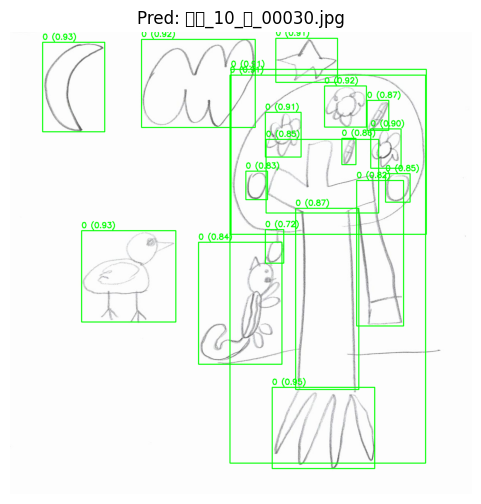

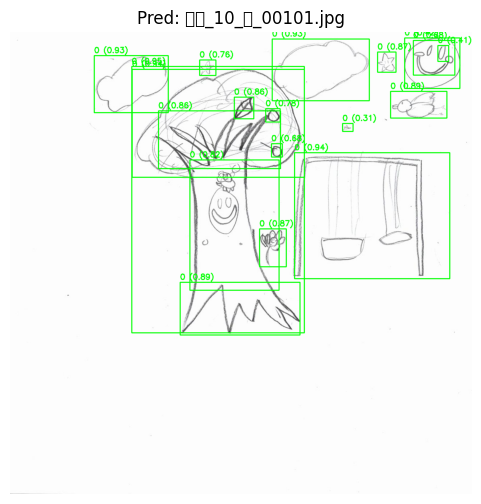

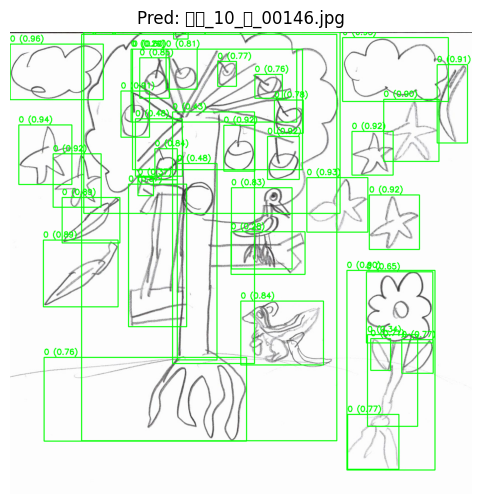

In [16]:
from ultralytics import YOLO
from pathlib import Path
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) 가장 최근 학습 run에서 best.pt 자동 탐색
def find_latest_best(exp_name="kids_drawing_yolov3"):
    base = Path("runs/detect")
    if not base.exists():
        return None
    exps = sorted([p for p in base.glob(f"{exp_name}*") if p.is_dir()], key=lambda p: p.stat().st_mtime, reverse=True)
    for exp in exps:
        ckpt = exp / "weights" / "best.pt"
        if ckpt.exists():
            return ckpt
    return None

best_ckpt = find_latest_best()
print("best.pt:", best_ckpt if best_ckpt else "Not found")

# 2) 모델 로드 (best가 있으면 그걸로, 없으면 현재 yolo 가중치 그대로)
if best_ckpt is not None:
    yolom = YOLO(str(best_ckpt))
else:
    yolom = yolo  # 직전에 학습한 객체가 메모리에 있으면 사용

# 3) 검증셋 평가 (mAP 등 지표)
metrics = yolom.val(
    data="data.yaml",
    imgsz=416,
    batch=16,
    workers=0,                 # Windows 안전
    device=0 if DEVICE=="cuda" else "cpu"
)
print("mAP50:", float(metrics.box.map50))
print("mAP50-95:", float(metrics.box.map))

# 4) 샘플 이미지들에서 예측 후 시각화
#    val 이미지 폴더에서 3장만 가져와서 그려보기
val_imgs_dir = Path("dataset_yolo/val/images")
sample_imgs = list(val_imgs_dir.glob("*.jpg"))[:3]
print("sample:", [p.name for p in sample_imgs])

if sample_imgs:
    results = yolom.predict(
        source=[str(p) for p in sample_imgs],
        imgsz=416,
        conf=0.25,             # 필요시 조정
        iou=0.6,               # 필요시 조정
        max_det=100,
        device=0 if DEVICE=="cuda" else "cpu",
        verbose=False
    )

    for img_path, r in zip(sample_imgs, results):
        # 한글 경로 대응하여 이미지 읽기
        img = cv2.imdecode(np.fromfile(str(img_path), dtype=np.uint8), cv2.IMREAD_COLOR)
        for b in r.boxes:
            x1, y1, x2, y2 = map(int, b.xyxy[0].cpu().numpy())
            cls_id = int(b.cls[0].cpu().numpy())
            conf = float(b.conf[0].cpu().numpy())
            label = f"{cls_id} ({conf:.2f})"
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img, label, (x1, max(0, y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {img_path.name}")
        plt.axis("off")
        plt.show()
else:
    print("⚠️ 'dataset_yolo/val/images' 안에 샘플 JPG가 없습니다.")


### 7. ResNet 분류기

탐지된 객체를 크롭 후 ResNet 분류 진행.

In [19]:
# === 셀 7A: YOLO 라벨(.txt)을 이용해 분류용 크롭 생성 ===
import os, math, shutil, glob
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# ==== 설정 ====
DATASET_ROOT = Path("dataset_yolo")  # 앞에서 만든 YOLO용 데이터 루트
OUT_CLS_ROOT = Path("dataset_cls")   # 분류 학습용 크롭이 저장될 폴더
CLASSES = ["나무", "남자사람", "여자사람", "집"]

# 크롭 저장 최소 크기, 패딩, 사각비 보정
MIN_SIDE = 24
PADDING = 4
MAKE_SQUARE = True

# 대용량일 때 빠르게 샘플만 만들고 싶으면 True / 전체는 False
FAST_DEBUG = False
MAX_PER_SPLIT = 5000   # FAST_DEBUG=True일 때 split별 최대 생성 수

def imread_unicode(path_str):
    """한글/공백 경로 안전 이미지 로드 (BGR)."""
    arr = np.fromfile(path_str, dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return img

def imwrite_unicode(path_str, img_bgr):
    """한글/공백 경로 안전 이미지 저장."""
    ext = os.path.splitext(path_str)[1]
    _, buf = cv2.imencode(ext, img_bgr)
    buf.tofile(path_str)

def yolo_txt_to_boxes(txt_path, img_w, img_h):
    """
    YOLO txt (class xc yc w h - normalized) -> pixel bbox list: (cls, x1,y1,x2,y2)
    """
    boxes = []
    with open(txt_path, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5: 
                continue
            cls_id = int(float(parts[0]))
            xc, yc, w, h = map(float, parts[1:])
            cx, cy = xc * img_w, yc * img_h
            bw, bh = w * img_w, h * img_h
            x1 = int(round(cx - bw/2))
            y1 = int(round(cy - bh/2))
            x2 = int(round(cx + bw/2))
            y2 = int(round(cy + bh/2))
            boxes.append((cls_id, x1, y1, x2, y2))
    return boxes

def safe_crop(img, x1, y1, x2, y2, padding=0, make_square=False):
    H, W = img.shape[:2]
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(W, x2 + padding)
    y2 = min(H, y2 + padding)
    if x2 <= x1 or y2 <= y1:
        return None

    if make_square:
        w, h = x2 - x1, y2 - y1
        side = max(w, h)
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
        x1 = max(0, cx - side // 2)
        y1 = max(0, cy - side // 2)
        x2 = min(W, x1 + side)
        y2 = min(H, y1 + side)

    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    if min(crop.shape[:2]) < MIN_SIDE:
        return None
    return crop

def build_split(split="train"):
    img_dir = DATASET_ROOT / split / "images"
    lbl_dir = DATASET_ROOT / split / "labels"
    out_split = OUT_CLS_ROOT / split
    # 클래스별 폴더 생성
    for cname in CLASSES:
        (out_split / cname).mkdir(parents=True, exist_ok=True)

    txt_list = sorted(glob.glob(str(lbl_dir / "*.txt")))
    made = 0

    for txt in tqdm(txt_list, desc=f"[{split}] Cropping for classification"):
        img_name = Path(txt).with_suffix(".jpg").name
        img_path = str(img_dir / img_name)
        if not Path(img_path).exists():
            # png 등 확장자 대체 시도
            alt = list((img_dir).glob(Path(img_name).stem + ".*"))
            if not alt:
                continue
            img_path = str(alt[0])

        img = imread_unicode(img_path)
        if img is None:
            continue
        H, W = img.shape[:2]
        boxes = yolo_txt_to_boxes(txt, W, H)
        for (cls_id, x1, y1, x2, y2) in boxes:
            if cls_id < 0 or cls_id >= len(CLASSES):
                continue
            crop = safe_crop(img, x1, y1, x2, y2, padding=PADDING, make_square=MAKE_SQUARE)
            if crop is None:
                continue

            # 파일명: 원본명_x1_y1_x2_y2.jpg
            out_dir = out_split / CLASSES[cls_id]
            out_name = f"{Path(img_name).stem}_{x1}_{y1}_{x2}_{y2}.jpg"
            imwrite_unicode(str(out_dir / out_name), crop)
            made += 1

            if FAST_DEBUG and made >= MAX_PER_SPLIT:
                return made
    return made

OUT_CLS_ROOT.mkdir(parents=True, exist_ok=True)
made_tr = build_split("train")
made_vl = build_split("val")
print(f"크롭 생성 완료! train {made_tr}개, val {made_vl}개 저장됨 → {OUT_CLS_ROOT}")


[val] Cropping for classification: 100%|██████████| 5600/5600 [04:07<00:00, 22.65it/s]

크롭 생성 완료! train 1088871개, val 136362개 저장됨 → dataset_cls


In [20]:
# === 셀 7B: ResNet 분류기 학습 ===
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224
BATCH = 64
EPOCHS = 1  # 먼저 짧게 돌려보고 성능/시간 보고 늘리기

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(root=str(OUT_CLS_ROOT/"train"), transform=train_tf)
val_ds   = datasets.ImageFolder(root=str(OUT_CLS_ROOT/"val"),   transform=val_tf)

print("클래스 인덱스 매핑:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# 모델 (ImageNet 사전학습 resnet18)
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=3e-4, weight_decay=1e-4)
best_acc = 0.0
best_path = "resnet_cls_best.pt"

for epoch in range(1, EPOCHS+1):
    resnet.train()
    tr_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = resnet(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * x.size(0)
    tr_loss /= len(train_loader.dataset)

    # 검증
    resnet.eval()
    correct = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = resnet(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
    val_acc = correct / max(1, len(val_loader.dataset))

    print(f"[Epoch {epoch}/{EPOCHS}] loss={tr_loss:.4f}  val_acc={val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": resnet.state_dict(), "classes": CLASSES}, best_path)
        print(f"  ↳ 최고 성능 갱신! 저장: {best_path}")

print(f"최종 최고 검증 정확도: {best_acc:.4f}")


클래스 인덱스 매핑: {'나무': 0, '남자사람': 1, '여자사람': 2, '집': 3}


KeyboardInterrupt: 

### 8. 후처리 (NMS + threshold)

In [ ]:
# === 셀 8: 후처리 유틸 ===
import torch
from torchvision.ops import nms

def postprocess_detections(boxes_xyxy, scores, classes, conf_thr=0.25, iou_thr=0.45, min_side=12, sort_by_x=True):
    """
    boxes_xyxy: Tensor[N,4]  (x1,y1,x2,y2)
    scores:     Tensor[N]
    classes:    Tensor[N] or list/np.array
    """
    if len(boxes_xyxy) == 0:
        return [], [], []
    # 신뢰도 필터
    keep = scores >= conf_thr
    boxes_xyxy = boxes_xyxy[keep]
    scores = scores[keep]
    classes = classes[keep]

    # 최소 크기 필터
    wh = boxes_xyxy[:, 2:4] - boxes_xyxy[:, 0:2]
    keep2 = (wh[:, 0] >= min_side) & (wh[:, 1] >= min_side)
    boxes_xyxy = boxes_xyxy[keep2]
    scores = scores[keep2]
    classes = classes[keep2]

    if len(boxes_xyxy) == 0:
        return [], [], []

    # NMS (클래스 무관)
    keep_idx = nms(boxes_xyxy, scores, iou_thr)
    boxes_xyxy = boxes_xyxy[keep_idx]
    scores = scores[keep_idx]
    classes = classes[keep_idx]

    # 좌->우 정렬 (읽기 편하게)
    if sort_by_x:
        order = torch.argsort(boxes_xyxy[:, 0])
        boxes_xyxy = boxes_xyxy[order]
        scores = scores[order]
        classes = classes[order]

    return boxes_xyxy.cpu().numpy(), scores.cpu().numpy(), classes.cpu().numpy()


### 9. 탐지 → 분류 연결

In [ ]:
# === 셀 9: 탐지→분류 파이프라인 (시각화 포함) ===
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

# 이미 앞 셀들에서 정의됐을 것들에 대한 안전장치
try:
    CLASSES
except NameError:
    CLASSES = ["나무", "남자사람", "여자사람", "집"]

try:
    DEVICE
except NameError:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

try:
    val_tf
except NameError:
    from torchvision import transforms
    val_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

# 1) YOLO 가중치: 앞서 학습한 run 경로 또는 사전학습(테스트용)
#    - 예: runs/detect/kids_drawing_yolov3/weights/best.pt
YOLO_WEIGHTS = os.environ.get("YOLO_WEIGHTS", "yolov3.pt")
yolo = YOLO(YOLO_WEIGHTS)

# 2) ResNet 불러오기 (셀 7B에서 학습 저장한 파일)
#    - 없으면 오류 안내
if not os.path.exists("resnet_cls_best.pt"):
    raise FileNotFoundError(
        "resnet_cls_best.pt 가 없습니다. 셀 7B를 먼저 실행해 ResNet 분류 가중치를 저장하세요."
    )

chkpt = torch.load("resnet_cls_best.pt", map_location=DEVICE)
resnet.load_state_dict(chkpt["model"])
resnet = resnet.to(DEVICE).eval()

# 3) 분류 전처리
infer_tf = val_tf

# 4) 후처리 유틸(필요시)
def postprocess_detections_xyxy(result, conf_thr_det=0.25, iou_thr=0.45):
    """
    Ultralytics 결과(result)에서 xyxy 박스/점수/클래스(id)를 numpy로 반환.
    추가적인 NMS는 Ultralytics 내부에서 수행되지만, 신뢰도 필터/정렬 등 적용.
    """
    if result.boxes is None or len(result.boxes) == 0:
        return np.empty((0,4), dtype=np.float32), np.array([]), np.array([])
    b = result.boxes
    boxes = b.xyxy.detach().cpu().numpy().astype(np.float32)  # (N,4)
    scores = b.conf.detach().cpu().numpy()                    # (N,)
    det_cls = b.cls.detach().cpu().numpy().astype(int)        # (N,)

    # 신뢰도 필터
    keep = scores >= conf_thr_det
    boxes, scores, det_cls = boxes[keep], scores[keep], det_cls[keep]

    # 좌→우 정렬(가독성)
    if len(boxes):
        order = np.argsort(boxes[:,0])
        boxes, scores, det_cls = boxes[order], scores[order], det_cls[order]
    return boxes, scores, det_cls

# 5) 한글 경로 안전 로더
def imread_unicode(path_str):
    arr = np.fromfile(path_str, dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return img

# 6) 박스 크롭→ResNet 분류
def crop_and_classify(img_bgr, box_xyxy):
    x1, y1, x2, y2 = map(int, box_xyxy)
    H, W = img_bgr.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W, x2), min(H, y2)
    if x2 <= x1 or y2 <= y1:
        return None, None

    crop = img_bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return None, None

    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(crop_rgb)
    x = infer_tf(pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = resnet(x)
        prob = torch.softmax(logits, dim=1)[0]
        cls_id = int(prob.argmax().item())
        conf = float(prob[cls_id].item())
    return cls_id, conf

# 7) 전체 파이프라인
def detect_and_classify(image_path, conf_thr_det=0.25, iou_thr=0.45, conf_thr_cls=0.50, draw_score=True):
    # 이미지 읽기 (한글 경로)
    img_bgr = imread_unicode(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지를 열 수 없습니다: {image_path}")

    # YOLO 추론
    results = yolo.predict(source=image_path, imgsz=416, conf=conf_thr_det, iou=iou_thr, verbose=False)
    r = results[0]

    # 박스 후처리
    boxes, det_scores, _ = postprocess_detections_xyxy(r, conf_thr_det, iou_thr)

    # 각 박스 분류
    vis = img_bgr.copy()
    for i, box in enumerate(boxes):
        cls_id, cls_conf = crop_and_classify(img_bgr, box)
        if cls_id is None:
            continue
        if cls_conf < conf_thr_cls:
            # 분류 신뢰도 낮으면 라벨 표시 생략(또는 '미확실'로 표시)
            label = f"? ({cls_conf:.2f})"
            color = (0, 165, 255)  # 주황
        else:
            label = f"{CLASSES[cls_id]} ({cls_conf:.2f})"
            color = (0, 255, 0)

        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        if draw_score:
            cv2.putText(vis, label, (x1, max(0, y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detection → Classification")
    plt.show()
    return boxes

# ===== 사용 예시 =====
# (학습 가중치가 준비되지 않았으면 YOLO만 동작하고, ResNet은 가중치가 필요합니다)
# 아래 샘플 이미지는 업로드된 데모 경로(컨테이너) 예시입니다. 로컬 경로로 바꿔서 써도 됩니다.
sample_paths = [
    "/mnt/data/남자사람_7_남_00026.jpg",
    "/mnt/data/여자사람_7_남_00231.jpg",
    "/mnt/data/나무_7_남_00242.jpg",
    "/mnt/data/집_7_남_00060.jpg",
]
for p in sample_paths:
    if os.path.exists(p):
        print("RUN:", p)
        detect_and_classify(p, conf_thr_det=0.25, iou_thr=0.45, conf_thr_cls=0.50)
